In [112]:
import wav_handler as wh
from matplotlib import pyplot as plt
from scipy import signal
import numpy as np
import dirtools as dt
import matplotlib.font_manager as fm
from matplotlib.ticker import MultipleLocator
import os
import matplotlib
import amplifier_model as am

In [12]:
# gs_font = fm.FontProperties(fname='../fonts/GillSans.ttc')

# plt.style.use('../styles/geriatric.mplstyle')

In [113]:
convertfactor = 106.373 / 1000 # +/- 2.126  / 1000 volts

def to_volts(amp):
    return convertfactor * amp


def get_resistance(name):
    num = ""
    for char in name:
        if char == "K":
            break
        num += char
    return float(num)

#get_freq("100.2Kohm")

541Kohm.wav 0.02220758
0.009092Kohm.wav 0.00083413883
0.564Kohm.wav 0.0010800485
0.018Kohm.wav 0.00083862006
30Kohm.wav 0.005272431
0.0046Kohm.wav 0.00083426374
0.201Kohm.wav 0.0009282036
0.988Kohm.wav 0.0012417878
99.345Kohm.wav 0.009751746
0.009092Kohm_v2.wav 0.0008377279
55.476Kohm.wav 0.0071546165
0.0520Kohm.wav 0.00085475564
9.8Kohm.wav 0.0030413566
14.9Kohm.wav 0.0037140814
3.9Kohm.wav 0.0020105694
298Kohm.wav 0.017534778
[5.4100e+05 9.0920e+00 5.6400e+02 1.8000e+01 3.0000e+04 4.6000e+00
 2.0100e+02 9.8800e+02 9.9345e+04 9.0920e+00 5.5476e+04 5.2000e+01
 9.8000e+03 1.4900e+04 3.9000e+03 2.9800e+05]
[0.02220758 0.00083414 0.00108005 0.00083862 0.00527243 0.00083426
 0.0009282  0.00124179 0.00975175 0.00083773 0.00715462 0.00085476
 0.00304136 0.00371408 0.00201057 0.01753478]


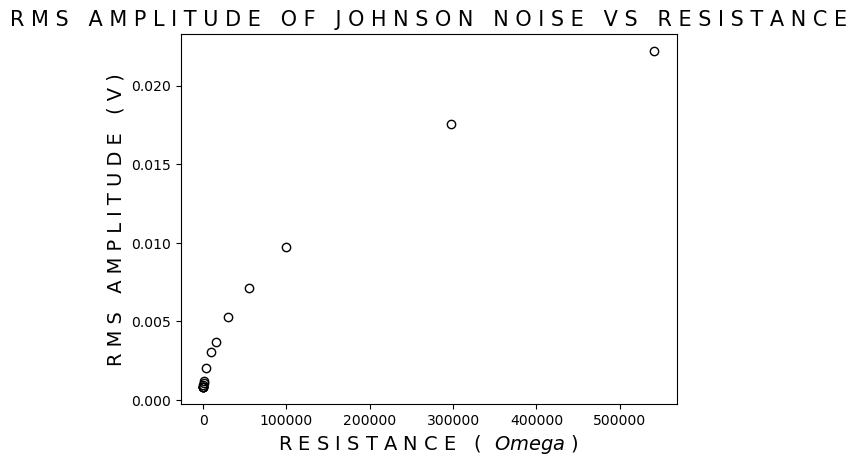

In [114]:
input_files = dt.get_files('../data_soundcard/johnson_noise_roundtwo/', fullpath=True)
fnames = dt.get_files('../data_soundcard/johnson_noise_roundtwo/')

rmses = []

for file, name in zip(input_files, fnames):
    t, d = wh.importWAV(file)
    rms = np.mean([np.sqrt(np.mean(to_volts(d["right"])**2)), np.sqrt(np.mean(to_volts(d["left"])**2))])
    print(name, rms)
    rmses.append([get_resistance(name) * 1000, rms])

rmses = np.array(rmses)
print(rmses[:,0])
print(rmses[:,1])

fig, ax = plt.subplots()
ax.set_title(' '.join('RMS AMPLITUDE OF JOHNSON NOISE VS RESISTANCE'),
             fontsize=15)

ax.scatter(rmses[:,0], rmses[:,1], color=[0,0,0,0], edgecolors='k')
ax.set_xlabel(" ".join("RESISTANCE ($\Omega$)"),
              fontsize=14)
ax.set_ylabel(" ".join("RMS AMPLITUDE (V)"),
              fontsize=14)
fig.savefig('resistances.svg', format='svg', dpi=1200)

In [115]:
def cross_correlate(s1, s2):
    return signal.csd(s1, s2, fs, nperseg=512)

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

Conversion using raw data -> periodogram. Leads to a lot of noise so we will use Welch's method in between


In [116]:

from scipy.signal import argrelextrema, welch
from numpy.fft import fft, ifft
import scipy.stats
import amplifier_model as am

fs = 44100

fname = "14.9Kohm.wav"
t, d = wh.importWAV("../data_soundcard/johnson_noise_roundtwo/" + fname)

v = np.mean([d["left"], d["right"]], axis=0)# cross_correlate(d["left"], d["right"])

# no welch - raw w/ csd
f, Pxx_den = cross_correlate(d["left"], d["right"])# signal.periodogram(v, fs, 'boxcar', scaling='density')

print(scipy.stats.mode(np.diff(f)).mode)
gain_model_squared = am.gain50(f, *am.measured_params)**2
poly_gain_squared = am.polymod(f)**2

86.1328125


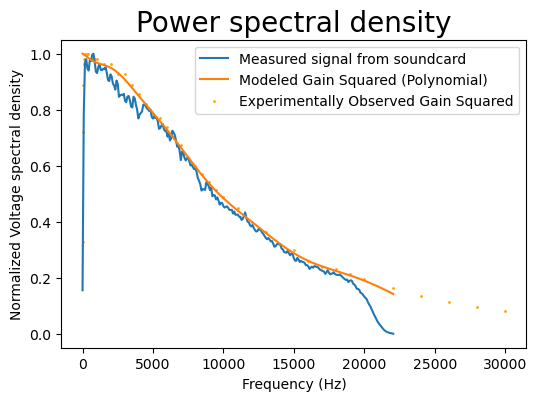

In [117]:
# PLOTTING

fig, ax = plt.subplots(figsize=(6,4))

# normalized data
ax.plot(f,Pxx_den / np.max(Pxx_den), label="Measured signal from soundcard")
ax.set_title('Power spectral density', fontsize=20)
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Normalized Voltage spectral density')
data = np.loadtxt("../data_manual/freq_char-amp50.csv", delimiter=",", skiprows=1)
# ax.plot(f, (gain_model_squared / np.max(gain_model_squared)), label="Modeled Gain Squared")
ax.plot(f, (poly_gain_squared / np.max(poly_gain_squared)), label="Modeled Gain Squared (Polynomial)")
ax.scatter(data[:,0], (data[:,4] / np.max(data[:,4]))**2,
           label="Experimentally Observed Gain Squared", c="orange",
          s=1)

ax.legend()

fig.savefig('psd1', format='svg', dpi=1200)

# ax.set_xlim(0, 500)
plt.show()


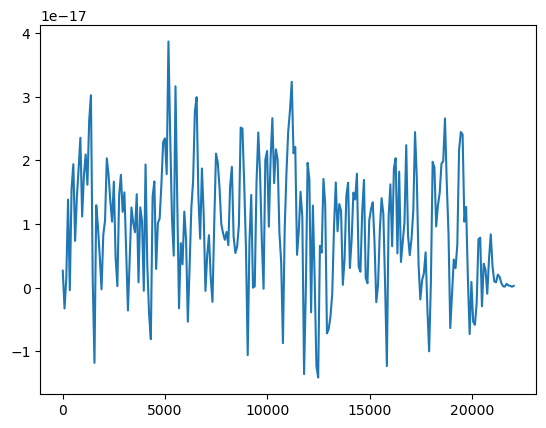

In [107]:
fname = "0.009092Kohm_v2.wav"
t, d = wh.importWAV("../data_soundcard/johnson_noise_roundtwo/" + fname)
f, Pxx_den = cross_correlate(d["left"], d["right"])# signal.periodogram(v, fs, 'boxcar', scaling='density')

fig, ax = plt.subplots()
slice = 10000
ax.plot(f[:slice],Pxx_den[:slice] / am.polymod(f)[:slice]**2, label="Measured signal from soundcard")

Apply normalization using model, truncate data to exclude aggressive filtering employed by the sound to avoid aliasing:

/opt/conda/lib/python3.11/site-packages/matplotlib/collections.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


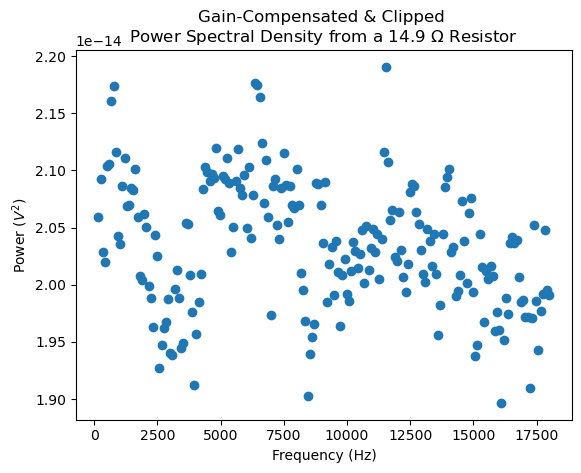

In [118]:
normalized = Pxx_den / poly_gain_squared
# truncation
start = 2
end = 210
f_clipped = f[start:end]
normalized_clipped = normalized[start:end]


fig, ax = plt.subplots()
ax.scatter(f_clipped, normalized_clipped)
ax.set_title("Gain-Compensated & Clipped \nPower Spectral Density from a {} $\\Omega$ Resistor".format(get_resistance(fname)))
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Power ($V^2}$)")
# ax.vlines(f_clipped[210], 0, np.max(normalized_clipped))
fig.savefig('clipped', format='svg', dpi=1200)

In [24]:
mask = np.where(np.logical_and(f > 2500, f < 12500))
f_clipped = f[mask]
normalized_clipped = normalized[mask]

fig, ax = plt.subplots()
ax.plot(f_clipped, normalized_clipped)
ax.set_title("Gain-Compensated & Clipped \nPower Spectral Density from a {} $\\KOmega$ Resistor".format(get_resistance(fname)))
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Power ($V^2$)")
# ax.vlines(f_clipped[210], 0, np.max(normalized_clipped))


Text(0, 0.5, 'Power ($V^2$)')

Error in callback <function _draw_all_if_interactive at 0x7fde6d7e7e20> (for post_execute):


ValueError: 
\KOmega
^
ParseFatalException: Unknown symbol: \KOmega, found '\'  (at char 0), (line:1, col:1)

ValueError: 
\KOmega
^
ParseFatalException: Unknown symbol: \KOmega, found '\'  (at char 0), (line:1, col:1)

<Figure size 640x480 with 1 Axes>

In [21]:
# calculate KB
delta_f = np.diff(f_clipped)[0]
V = np.mean(normalized_clipped)
print(np.mean(normalized_clipped)/(4 * 295 * 1000 * delta_f))

1.1269953482179735e-17


Beginnings of looking into cross-correlation

In [1]:
plt.plot(t, d["left"], t, d["right"]) # signal comparison
plt.show()
u = d["left"] * d["right"]
# plt.plot(t[u >= 0], u[u >= 0])

f, y = scipy.signal.csd(d["left"], d["right"], fs)
normalized = am.polymod(f)**2

NameError: name 'plt' is not defined

In [20]:
f_clipped = f# [mask]
normalized_clipped = normalized# [mask]

plt.plot(f_clipped, y / normalized_clipped)

NameError: name 'y' is not defined